In [1]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
def chi_pattern(x, amp=1,gammap=1e-3, ld=15, tg=1, f=1, L=0.6):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    aoo : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    g_p = gammap
    w = 2 * np.pi * f
#     ao = models.calc_ao(aoo, po2, po2_ref)

    chi = -amp /(1 +  g_p * np.sqrt(1 + 1j * tg * w)) \
    * np.exp(-x / ld * np.sqrt(1 + 1j * tg * w))
    # Note gamma_p = gamma * L / ld
    return chi

def chi_surf_diff(x, amp=1, gammap=1e-3, ld=15, tg=1, nu=1e-3, f=1, L=0.6):

    g_p = gammap
    w = 2 * np.pi * f
    numer = -amp * np.sqrt(1+ 2 * nu) * np.exp(-(x/ ld)*np.sqrt(1 + 1j * tg * w)/np.sqrt(1 + 2 * nu))
    denom = (np.sqrt(1 + 2 * nu) + g_p * np.sqrt(1 + 1j * tg * w) * (1 - 2 * nu))
#     chi = - amp * np.sqrt(1+2*nu)*np.exp(-(x+yd)/ld*(np.sqrt(1+1j*w*tg)/np.sqrt(1+2*nu)))/(np.sqrt(1+2*nu)+g_p*np.sqrt(1+1j*w*tg)-2*g_p*nu*np.sqrt(1+1j*w*tg))
    chi = numer / denom
    # Note gamma_p = gamma * L / ld
    return chi

In [3]:
starts = [[4, 0, 2, 3], [6, 0, 6, 0], [0, 0,2]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f = hdf5_io.get_all_datasets('..\\Model Fitting\July18_frXAS_LV_Analyzed', harmonic=1, start_indices=starts) 
f1 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=1, start_indices=starts) 
f2 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=2, start_indices=starts) 
f3 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=3, start_indices=starts) 
f4 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=4, start_indices=starts) 
hdf5_io.close_hdf5('..\\Model Fitting\\July18_frXAS_Py_Analyzed')
hdf5_io.close_hdf5('..\\Model Fitting\July18_frXAS_LV_Analyzed')

In [4]:
x, data4, frequencies, gases, sizes = hdf5_io.unpack_data(f4, kind='adj')
x, data3, frequencies, gases, sizes = hdf5_io.unpack_data(f3, kind='adj')
x, data2, frequencies, gases, sizes = hdf5_io.unpack_data(f2, kind='adj')
x, data1, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')
x0, data0, frequencies0, gases0, sizes0 = hdf5_io.unpack_data(f, kind='adj')

In [5]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

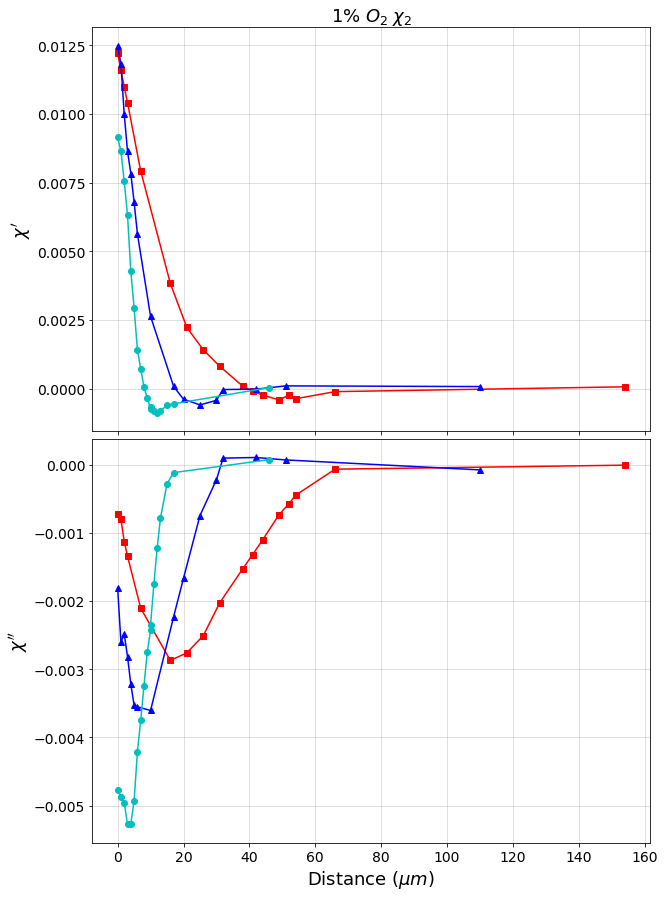

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
axes[0].set_title('1% $O_2 \; \chi_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Chi2 1%O2.png', dpi=400, bbox_inches='tight')

In [7]:
fit_params = Parameters()

for iy, data in enumerate(data1):
    fit_params.add(f'amp_{iy+1}', value=-data[0].real/.9, min=-1, max=-1e-3)
    fit_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    fit_params.add(f'ld_{iy+1}', value=15, min=1e-9, max=100)
    fit_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    fit_params.add(f'f_{iy+1}', value=frequencies[iy], vary=False)
    fit_params.add(f'L_{iy+1}', value=6e-1, vary=False)

# Setting other parameters within each dataset to be equal
t_1 = 4
t_10 = 8
t_100 = 11
for iy in np.arange(0, sizes[0]):
    if (iy+1) != t_1:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_1}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_1}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_1}'

for iy in np.arange(sizes[0], sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_10}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_10}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_10}'

for iy in np.arange(sum(sizes[:2]), len(data1)):
    if (iy+1) != t_100:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_100}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_100}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_100}'

In [16]:
fit_params2 = Parameters()

for iy, data in enumerate(data1):
    fit_params2.add(f'amp_{iy+1}', value=-data[0].real/.9, min=-1, max=-1e-3)
    fit_params2.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=1)
    fit_params2.add(f'ld_{iy+1}', value=15, min=1e-9, max=100)
    fit_params2.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    fit_params2.add(f'nu_{iy+1}', value=1e-4, min=0, max=10)
    fit_params2.add(f'f_{iy+1}', value=frequencies[iy], vary=False)
    fit_params2.add(f'L_{iy+1}', value=6e-1, vary=False)

# Setting other parameters within each dataset to be equal
t_1 = 4
t_10 = 8
t_100 = 11
for iy in np.arange(0, sizes[0]):
    if (iy+1) != t_1:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_1}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_1}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_1}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_1}'

for iy in np.arange(sizes[0], sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_10}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_10}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_10}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_10}'

for iy in np.arange(sum(sizes[:2]), len(data1)):
    if (iy+1) != t_100:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_100}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_100}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_100}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_100}'

In [8]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data1, chi_pattern))
# mini2=lmfit.Minimizer(models.objective_fun, fit_params2, fcn_args=(x, data1, chi_surf_diff))

In [10]:
out = mini.minimize(method='leastsq')
# out2 = mini2.minimize(method='leastsq')
# Saving report fit to a text file
save_fit_report(f'..\\Fit Reports\\LeastSQ_F3_Pinned_Params_AmpDataInit.txt', out, starts)
print('\u03A7_red = ', out.redchi)
print(fit_report(out))
# print('\u03A7_red = ', out2.redchi)
# print(fit_report(out2))

Χ_red =  5.245588134562324e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 283
    # data points      = 1024
    # variables        = 20
    chi-square         = 0.00526657
    reduced chi-square = 5.2456e-06
    Akaike info crit   = -12430.1160
    Bayesian info crit = -12331.4866
[[Variables]]
    amp_1:     -0.08833940 +/- 0.00267402 (3.03%) (init = -0.08497292)
    gammap_1:   0.05521436 +/- 0.03038853 (55.04%) == 'gammap_4'
    ld_1:       38.3792386 +/- 0.51608158 (1.34%) == 'ld_4'
    tg_1:       3.26110351 +/- 0.66328790 (20.34%) == 'tg_4'
    f_1:        0 (fixed)
    L_1:        0.6 (fixed)
    amp_2:     -0.01283522 +/- 0.00127788 (9.96%) (init = -0.01356824)
    gammap_2:   0.05521436 +/- 0.03038853 (55.04%) == 'gammap_4'
    ld_2:       38.3792386 +/- 0.51608158 (1.34%) == 'ld_4'
    tg_2:       3.26110351 +/- 0.66328790 (20.34%) == 'tg_4'
    f_2:        0.25 (fixed)
    L_2:        0.6 (fixed)
    amp_3:     -0.01442536 +/- 0.00165953 (11

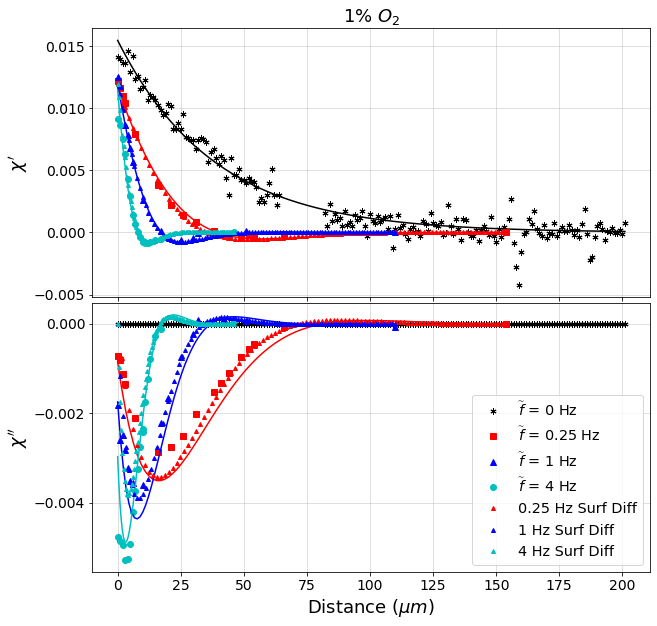

In [41]:
# DC scaling
DC_ind = 0
amp0 = 1
gammap0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

scale = np.abs(chi_pattern(0, amp0, gammap0, ld0, tg0, f0, L0))
norm = -out.params[f'amp_{DC_ind+2}']/(data1[DC_ind][0]*scale)


fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out2.params, DC_ind, y, chi_surf_diff)*norm,
                       color=colors[0], marker='')

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')

for iy in np.arange( 
    1,sizes[0]):
#     sizes[0]+1,sum(sizes[:2])):
#     sum(sizes[:2])+1,sum(sizes)):

    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='', ls='-')
for iy in np.arange( 
    1,sizes[0]):
#     sizes[0]+1,sum(sizes[:2])):
#     sum(sizes[:2])+1,sum(sizes)):

    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out2.params, iy, y, chi_surf_diff),
                           color=colors[iy], marker='^', ls='', ms=4,
                           label=str(frequencies[iy]) + ' Hz Surf Diff')

axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern Amp Model wo yd 1%O2.png', dpi=400, bbox_inches='tight')

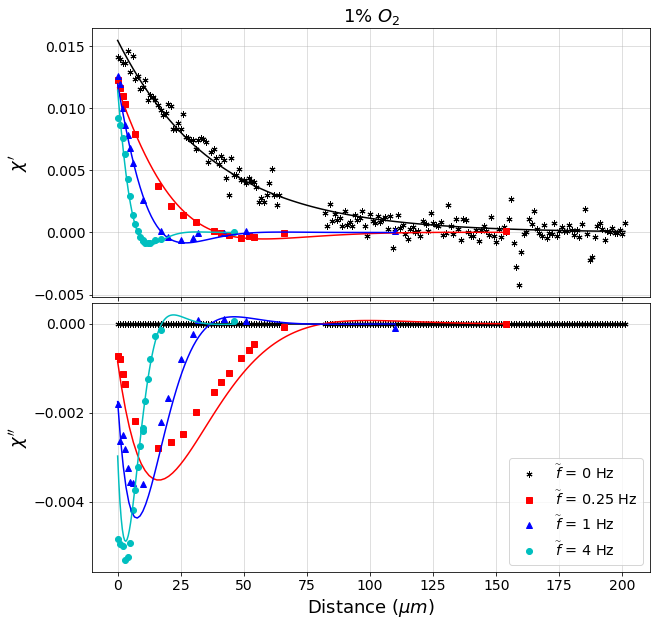

In [15]:
# DC scaling
DC_ind = 0
amp0 = 1
gamma_p0 = out.params[f'gamma_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
yd0 = out.params[f'yd_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

scale = np.abs(chi_pattern(0, amp0, gamma_p0, ld0, tg0, yd0, f0, L0))
norm = -out.params[f'amp_{DC_ind+2}']/(data1[DC_ind][0]*scale)


fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, x[DC_ind], data[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, chi_pattern)*norm,
                       color=colors[0], marker='')

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')
for iy in np.arange(1,sizes[0]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern Amp Model wo yd 1%O2.png', dpi=400, bbox_inches='tight')

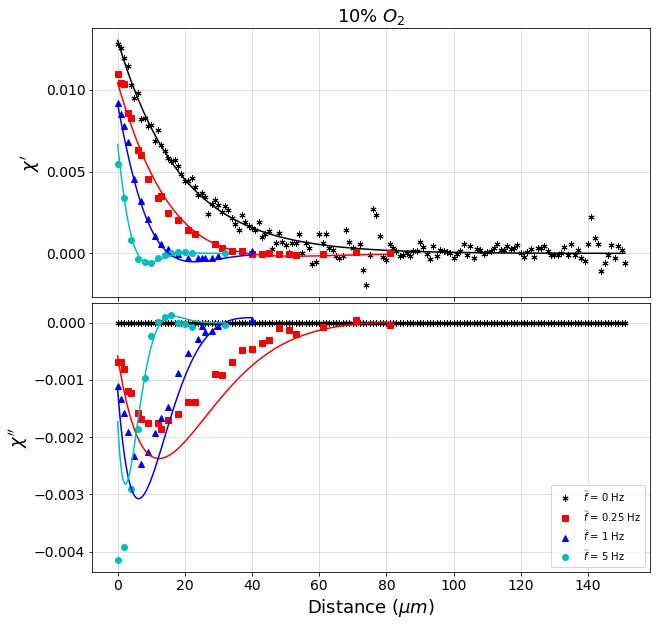

In [288]:
# DC scaling
DC_ind = sizes[0]
amp0 = 1
gamma_p0 = out.params[f'gamma_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
yd0 = out.params[f'yd_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

scale = np.abs(chi_pattern(0, amp0, gamma_p0, ld0, tg0, yd0, f0, L0))
norm = -out.params[f'amp_{DC_ind+2}']/(data1[DC_ind][0]*scale)

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, chi_pattern)*norm,
                       color=colors[0], marker='')

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('10% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend()
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern Amp Model wo yd 10%O2.png', dpi=400, bbox_inches='tight')

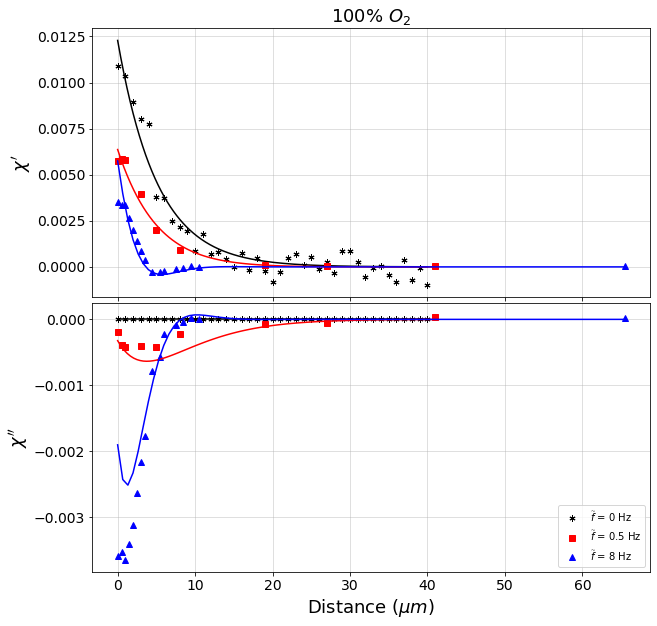

In [289]:
# DC scaling
DC_ind = sum(sizes[:2])
amp0 = 1
gamma_p0 = out.params[f'gamma_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
yd0 = out.params[f'yd_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

scale = np.abs(chi_pattern(0, amp0, gamma_p0, ld0, tg0, yd0, f0, L0))
norm = -out.params[f'amp_{DC_ind+2}']/(data1[DC_ind][0]*scale)

fig, axes = plt.subplots(nrows=2, figsize=(10,10))


# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data[DC_ind]*norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, chi_pattern)*norm,
                       color=colors[0], marker='')


for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='', 
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('100% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend()
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern Amp Model wo yd 100%O2.png', dpi=400, bbox_inches='tight')

In [ ]:
0.05683500 * 38.3795747 / .65

In [ ]:
0.14298715 * 18.9187704 / .65

In [ ]:
20.0465491 * 5.10403594 /.65

In [ ]:
58.32/3329